In [16]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm


# Authenticate with W&B
wandb.login(timeout=1024)

# Configure project and other parameters if necessary
project_name = "run_away_sac_explore"
entity = "pletctj6"

# Retrieve the runs from the project
api = wandb.Api()
runs = api.runs(f"{entity}/{project_name}")

# Initialize a list to store coverage and shannon entropy data
experiments_data = {}
nb_max_samples = int(1e6)
TOTAL_TIME_STEPS = 2_000_000
TOTAL_POINTS = 1_000
NUM_ENVS = 4

### Downloading the data

* config : config for the run
* history : Time evolution of all the data recorded during the run as columns in a pandas dataframe
* summary : last sample of the data recorded

In [17]:
from envs.config_env import config as config_env

def process_run(run, 
                metrics = {
                            "config": ["exp_name", "env_id", "seed", "keep_extrinsic_reward", "beta_ratio", "name"],
                            "history": ["charts/shannon_entropy", "charts/coverage",  "_step"],
                            "summary": ["charts/shannon_entropy", "charts/coverage",  "_step"]
                },
                config_env=config_env):
    # Vérification de l'état du run
    # if run.state != "finished":
    #     # print(f"Skipping run {run.name} because it is not finished.")
    #     return None
    ##### CONFIGURATION #####
    config = run.config
    config_metrics = {key: None for key in metrics['config']}
    for key in config_metrics.keys():
        try:
            config_metrics[key] = config.get(key)
        except:
            print(f"Skipping run {run.name} because it doesn't have the data {key} in config.")
            return None
        
    ##### HISTORY #####
    history_metrics_full = run.history(samples=nb_max_samples, keys=metrics['history'], x_axis="_step", pandas=(True), stream="default")
    history_metrics = {key: None for key in metrics['history']}
    for key in history_metrics.keys():
        try : 
            history_metrics[key] = history_metrics_full[key]
        except:
            print(f"Skipping run {run.name} because it doesn't have the data {key} in history.")
            return None

    ##### SUMMARY #####
    summary_metrics = {key: None for key in metrics['summary']}
    for key in summary_metrics.keys():
        if key in run.summary:
            summary_metrics[key] = run.summary._json_dict[key]
        else:
            summary_metrics[key] = history_metrics[key].iloc[-1]
        
    # Check env id 
    type_id = config_env[run.config.get('env_id')]['type_id']
    return {
        'exp_name': config_metrics['exp_name'],
        'env_name': config_metrics['env_id'],
        'type_id': type_id,
        'seed': config_metrics['seed'],
        'data': {
            'summary_metrics': summary_metrics,
            'history_metrics': history_metrics,
            'config_metrics': config_metrics,
            'config': config
        }
    }

experiments_data = {}
max_workers = 4
# Utilisation de ThreadPoolExecutor pour paralléliser les exécutions de runs
# Spécifiez le nombre de threads avec max_workers, par exemple 4 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_run, run) for run in runs}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing runs"):
        result = future.result()
        if result is not None:
            exp_name = result['exp_name']
            env_name = result['env_name']
            type_id = result['type_id']
            seed = result['seed']
            data = result['data']
            if exp_name not in experiments_data:
                experiments_data[exp_name] = {}
            if type_id not in experiments_data[exp_name]:
                experiments_data[exp_name][type_id] = {}
            if env_name not in experiments_data[exp_name][type_id]:
                experiments_data[exp_name][type_id][env_name] = {}
            if seed in experiments_data[exp_name][type_id][env_name].keys():
                if experiments_data[exp_name][type_id][env_name][seed]['history_metrics']['charts/coverage'].max() < data['history_metrics']['charts/coverage'].max():
                    experiments_data[exp_name][type_id][env_name][seed] = data
            else:
                experiments_data[exp_name][type_id][env_name][seed] = data


Processing runs:   0%|          | 0/440 [00:00<?, ?it/s]

#### Checks

In [18]:
# algo
list_algos = list(experiments_data.keys())
# type
list_type = list(experiments_data[list_algos[0]].keys())
# env
list_env = []
for i in range(len(list_type)):
    list_env += list(list(experiments_data[list_algos[0]][list_type[i]].keys()))

print(list_algos)
print(list_type)
print(list_env)

['v2wsac', 'aux_sac', 'apt_sac', 'v2klsac', 'v1klsac', 'v1wsac']
['robotics', 'maze', 'mujoco']
['FetchReach-v1', 'FetchPush-v2', 'FetchSlide-v2', 'Maze-Easy-v0', 'Maze-Hard-v0', 'Maze-Ur-v0', 'HalfCheetah-v3', 'Humanoid-v3', 'Ant-v3', 'Walker2d-v3', 'Hopper-v3']


### Traductor utils 

In [19]:
def traductor_exp(exp_name:str):
    return exp_name 


### Table final coverage

In [30]:
import pandas as pd
import numpy as np
import os
from tabulate import tabulate

def extract_final_values(experiments_data, 
                        keys=['charts/coverage', 'charts/shannon_entropy'],
                        type_id_default = None, 
                        env_name_default = None):
    key_data = {}
    for exp_name in experiments_data.keys():
        for type_id in experiments_data[exp_name].keys():
            if type_id_default is not None and type_id not in type_id_default:
                continue
            for env_name in experiments_data[exp_name][type_id].keys():
                if env_name_default is not None and env_name not in env_name_default:
                    continue
                for seed in experiments_data[exp_name][type_id][env_name].keys():
                    run_data = experiments_data[exp_name][type_id][env_name][seed]
                    for key in keys:
                        if key not in key_data:
                            key_data[key] = []
                        metric = run_data['summary_metrics'][key]
                        key_data[key].append({
                            'exp_name': traductor_exp(exp_name),
                            'env_name': env_name,
                            'seed': seed,
                            key: metric
                        })
    key_df = {}
    for key in keys:
        key_df[key] = pd.DataFrame(key_data[key])
    return key_df 

# Fonction pour normaliser le coverage par le coverage maximal de l'environnement
def normalize(df, key):
    normalized_df = df[key].copy()
    normalized_df[key+'_max'] = normalized_df.groupby(['exp_name'])[key].transform('max')
    normalized_df[key+'_mean'] = normalized_df.groupby(['exp_name', 'env_name'])[key].transform('mean')
    normalized_df[key+'_std'] = normalized_df.groupby(['exp_name', 'env_name'])[key].transform('std')
    normalized_df[key+'_ste'] = normalized_df.groupby(['exp_name', 'env_name'])[key].transform('sem')
    
    # normalized_df[key+'_normalized_mean'] = (normalized_df[key+'_mean'] / np.abs(normalized_df[key+'_max'])) * 100
    # normalized_df[key+'_normalized_std'] = (normalized_df[key+'_std'] / np.abs(normalized_df[key+'_max'])) * 100
    # normalized_df[key+'_normalized_ste'] = (normalized_df[key+'_ste'] / np.abs(normalized_df[key+'_max'])) * 100

    normalized_df[key+'_normalized_mean'] = normalized_df[key+'_mean'] 
    normalized_df[key+'_normalized_std'] = normalized_df[key+'_std'] 
    normalized_df[key+'_normalized_ste'] = normalized_df[key+'_ste'] 

    
    normalized_df = normalized_df[['exp_name', 'env_name', key+'_normalized_mean', key+'_normalized_std', key+'_normalized_ste']].drop_duplicates()
    return normalized_df


def format_results(df, value_col_mean, value_col_std):
    formatted_results = df.pivot(index='exp_name', columns='env_name', values=[value_col_mean, value_col_std])
    formatted_results = formatted_results.swaplevel(axis=1).sort_index(axis=1, level=0)
    for env in formatted_results.columns.levels[0]:
        formatted_results[(env, 'mean +/- std')] = formatted_results[(env, value_col_mean)].round(2).astype(str) + " +/- " + formatted_results[(env, value_col_std)].round(2).astype(str)
    formatted_results = formatted_results.loc[:, pd.IndexSlice[:, 'mean +/- std']]
    formatted_results.columns = formatted_results.columns.droplevel(1)
    return formatted_results

# def dataframe_to_markdown(df, filename):
#     # Apply bold formatting to each row
#     # df_bold = df.apply(bold_max_in_row, axis=1)
#     # Convert DataFrame to Markdown table format
#     markdown_table = tabulate(df, headers='keys', tablefmt='pipe', showindex=True)
#     # Save the Markdown table to a file
#     filename = filename.replace('/', '_')
#     with open(filename, 'w') as f:
#         f.write(markdown_table)

def dataframe_to_markdown(df, filename):
    def bold_max_in_column(df):
        df_bold = df.copy()
        for col in df.columns:
            if col != 'exp_name':
                max_value = df[col].apply(lambda x: float(x.split(' +/- ')[0])).max()
                df_bold[col] = df[col].apply(lambda x: f"**{x}**" if float(x.split(' +/- ')[0]) == max_value else x)
        return df_bold
    
    # Apply bold formatting to each column
    df_bold = bold_max_in_column(df)
    
    # Convert DataFrame to Markdown format
    markdown_table = tabulate(df_bold, headers='keys', tablefmt='pipe', showindex=True)
    
    # Replace '/' in filename
    filename = filename.replace('/', '_')
    
    # Write the Markdown table to a file
    with open(filename, 'w') as f:
        f.write(markdown_table)

def dataframe_to_latex(df, filename='latex_table.txt', save=False):
    def bold_max_in_column(df):
        df_bold = df.copy()
        for col in df.columns:
            if col != 'exp_name':
                max_value = df[col].apply(lambda x: float(x.split(' +/- ')[0])).max()
                df_bold[col] = df[col].apply(lambda x: f"\\textbf{{{x}}}" if float(x.split(' +/- ')[0]) == max_value else x)
        return df_bold
    
    # Apply bold formatting to each column
    df_bold = bold_max_in_column(df)
    
    # Convert DataFrame to LaTeX format
    latex_table = tabulate(df_bold, headers='keys', tablefmt='latex', showindex=True)
    
    # Correct the LaTeX syntax
    latex_table = latex_table.replace(r'\textbackslash{}', '\\').replace(r'\\textbf', r'\textbf').replace(r'\{', '{').replace(r'\}', '}')
    
    # Replace '/' in filename
    filename = filename.replace('/', '_')
    
    if save:
        # Delete file if it already exists
        if os.path.exists(filename):
            os.remove(filename)
        with open(filename, 'w') as f:
            f.write(latex_table)
    
    return latex_table



# Extraction des valeurs finales
for type_id in list_type:
    key_df = extract_final_values(experiments_data, type_id_default=[type_id], env_name_default=list(experiments_data[list_algos[0]][type_id].keys()))
    for key in key_df.keys():
        # coverage normalization 
        data_normalized_df = normalize(key_df, key)
        # # Formater les résultats
        data_formatted = format_results(data_normalized_df, key+'_normalized_mean', key+'_normalized_ste')
        # # # Enregistrement des DataFrames au format Markdown
        # # dataframe_to_markdown(coverage_formatted, 'coverage_normalized.md')
        # dataframe_to_markdown(data_formatted, 'shannon_entropy.md')

        # # Enregistrement des DataFrames au format LaTeX
        dataframe_to_latex(data_formatted, f'{key}_{type_id}_normalized.tex', save=True if 'mu' not in key else False)

        # mise en forme en markdown
        # dataframe_to_markdown(data_formatted, f'{key}_{type_id}_normalized.md')
        # Affichage des résultats
        print(key + " " + type_id +" Normalized DataFrame:")
        print(tabulate(data_formatted, headers='keys', tablefmt='pipe', showindex=True))



charts/coverage robotics Normalized DataFrame:
| exp_name   | FetchPush-v2   | FetchReach-v1   | FetchSlide-v2   |
|:-----------|:---------------|:----------------|:----------------|
| apt_sac    | 40.39 +/- 1.6  | 1.48 +/- 0.05   | 93.14 +/- 4.4   |
| aux_sac    | 8.94 +/- 0.4   | 0.49 +/- 0.0    | 47.29 +/- 1.05  |
| v1klsac    | 10.49 +/- 1.4  | 1.46 +/- 0.06   | 34.69 +/- 2.76  |
| v1wsac     | 15.2 +/- 2.75  | 2.03 +/- 0.04   | 49.88 +/- 2.84  |
| v2klsac    | 22.15 +/- 1.6  | 0.3 +/- 0.03    | 51.27 +/- 5.34  |
| v2wsac     | 10.3 +/- 3.63  | 1.23 +/- 0.29   | 17.24 +/- 8.81  |
charts/shannon_entropy robotics Normalized DataFrame:
| exp_name   | FetchPush-v2   | FetchReach-v1   | FetchSlide-v2   |
|:-----------|:---------------|:----------------|:----------------|
| apt_sac    | 7.07 +/- 0.07  | 8.3 +/- 0.03    | 7.79 +/- 0.4    |
| aux_sac    | 5.16 +/- 0.01  | 6.87 +/- 0.0    | 4.1 +/- 0.08    |
| v1klsac    | 5.17 +/- 0.02  | 8.29 +/- 0.07   | 4.2 +/- 0.3     |
| v1wsac     | 

### Data cleaning

In [22]:


# Fonction pour vérifier si une liste est vide
def is_not_empty(obj):
    if isinstance(obj, pd.Series):
        return not obj.empty
    return bool(obj)

def interpolate_and_fill_single_metric(values, global_steps, max_global_step):
    values = values.dropna()
    # Créer une série avec des NaNs pour les global_steps manquants
    all_steps = np.arange(max_global_step + 1)
    series = values.reindex(all_steps).interpolate(method='linear').ffill().bfill()
    return series

def add_nomalized_data(experiments_data, keys=['charts/coverage', '_step']):
    # final data 
    data = {}
    # max data evaluation 
    dict_max = {}
    for exp_name in experiments_data.keys():
        for type_id in experiments_data[exp_name].keys():
            for env_name in experiments_data[exp_name][type_id].keys():
                dict_max[env_name] = {} if env_name not in dict_max else dict_max[env_name]
                for seed in experiments_data[exp_name][type_id][env_name].keys():
                    for key in keys:
                        if key not in dict_max[env_name]:
                            dict_max[env_name][key] = experiments_data[exp_name][type_id][env_name][seed]['summary_metrics'][key]
                        else : 
                            dict_max[env_name][key] = max(dict_max[env_name][key], experiments_data[exp_name][type_id][env_name][seed]['summary_metrics'][key])
                        # nb_values
                        if "nb_values" not in dict_max[env_name]: dict_max[env_name]["nb_values"] = experiments_data[exp_name][type_id][env_name][seed]['history_metrics'][key].shape[0]  
                        else : dict_max[env_name]["nb_values"] = max(experiments_data[exp_name][type_id][env_name][seed]['history_metrics'][key].shape[0], dict_max[env_name]["nb_values"])
    # add normalized data
    for exp_name in experiments_data.keys():
        data[exp_name] = {} if exp_name not in data else data[exp_name]
        for type_id in experiments_data[exp_name].keys():
            data[exp_name][type_id] = {} if type_id not in data[exp_name] else data[exp_name][type_id]
            for env_name in experiments_data[exp_name][type_id].keys():
                data[exp_name][type_id][env_name] = {} if env_name not in data[exp_name][type_id] else data[exp_name][type_id][env_name]
                for key in keys:
                    if key == '_step':
                        continue
                    data_seeds = []
                    for seed in experiments_data[exp_name][type_id][env_name].keys():
                        run_data = experiments_data[exp_name][type_id][env_name][seed]
                        values = run_data['history_metrics'][key]
                        # repeat last value nb_values-values times
                        df_comp = pd.Series(np.repeat(values.iloc[-1], dict_max[env_name]["nb_values"]-values.shape[0]))
                        values = pd.concat([values, df_comp]).values.reshape(-1, 1)
                        data_seeds.append(pd.Series(values.flatten()))
                
                    df_concat = pd.concat(data_seeds, axis=1)
                    df_mean = (df_concat.mean(axis=1)/dict_max[env_name][key])*100.0
                    df_std = (df_concat.std(axis=1)/dict_max[env_name][key])*100.0
                    df_ste = (df_concat.sem(axis=1)/dict_max[env_name][key])*100.0
                    # df_mean = (df_concat.mean(axis=1)/dict_max[env_name][key])*100.0
                    # df_std = (df_concat.std(axis=1)/dict_max[env_name][key])*100.0
                    # df_ste = (df_concat.sem(axis=1)/dict_max[env_name][key])*100.0
                    data[exp_name][type_id][env_name]['normalized_mean_'+key] = df_mean
                    data[exp_name][type_id][env_name]['normalized_std_'+key] = df_std
                    data[exp_name][type_id][env_name]['normalized_ste_'+key] = df_ste
                data[exp_name][type_id][env_name]['_step'] = run_data['history_metrics']['_step']
                data[exp_name][type_id][env_name]['max_step'] = dict_max[env_name]["_step"]
    return data
                    
                        
        
data_clean = add_nomalized_data(experiments_data)

### Plotting

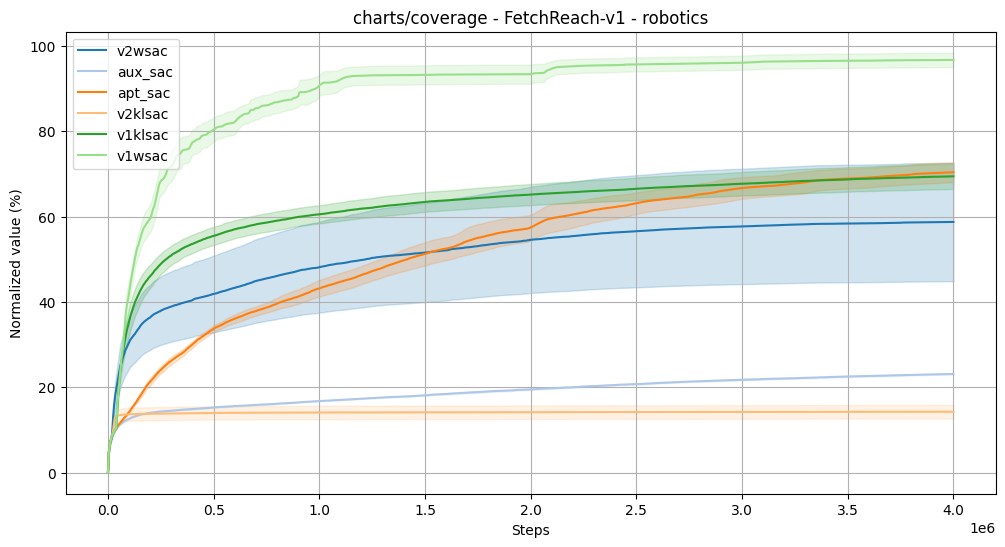

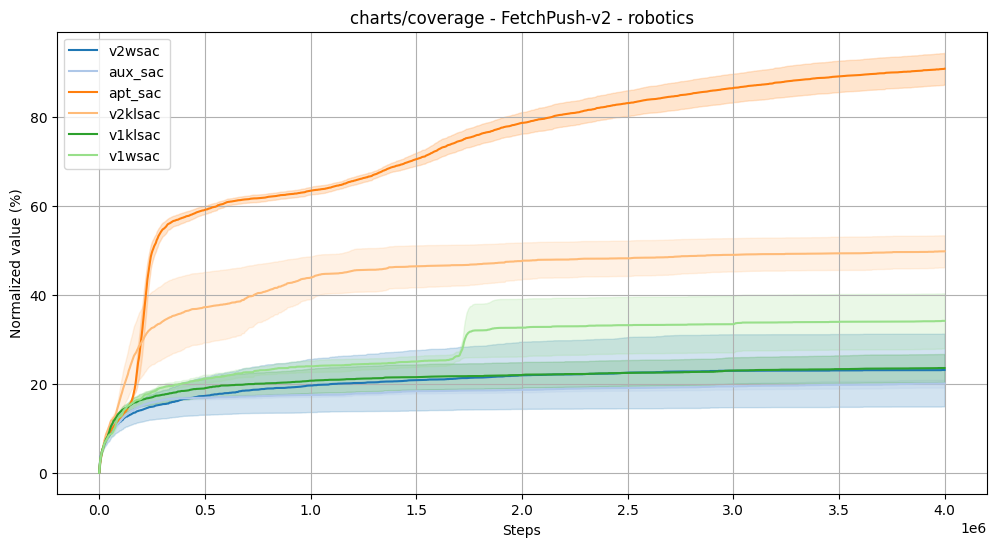

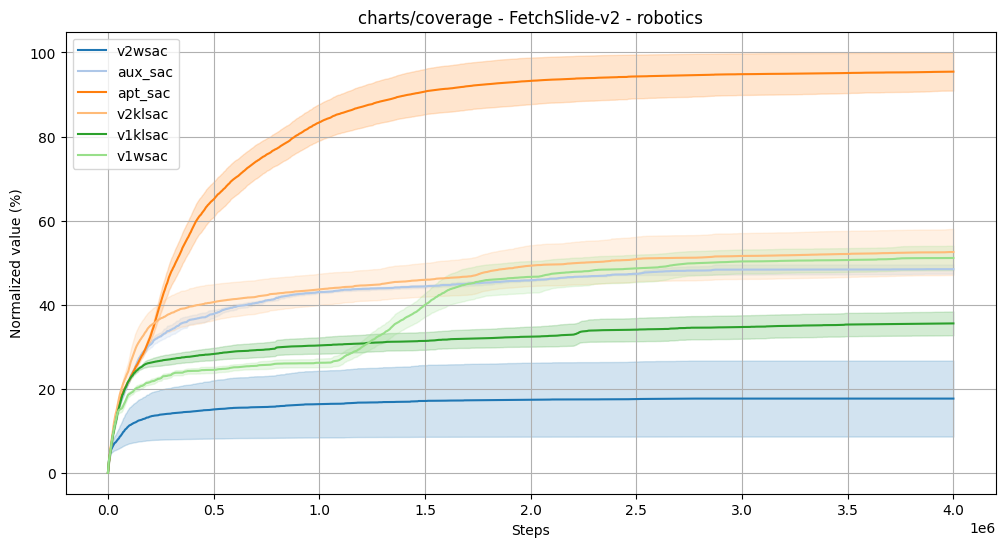

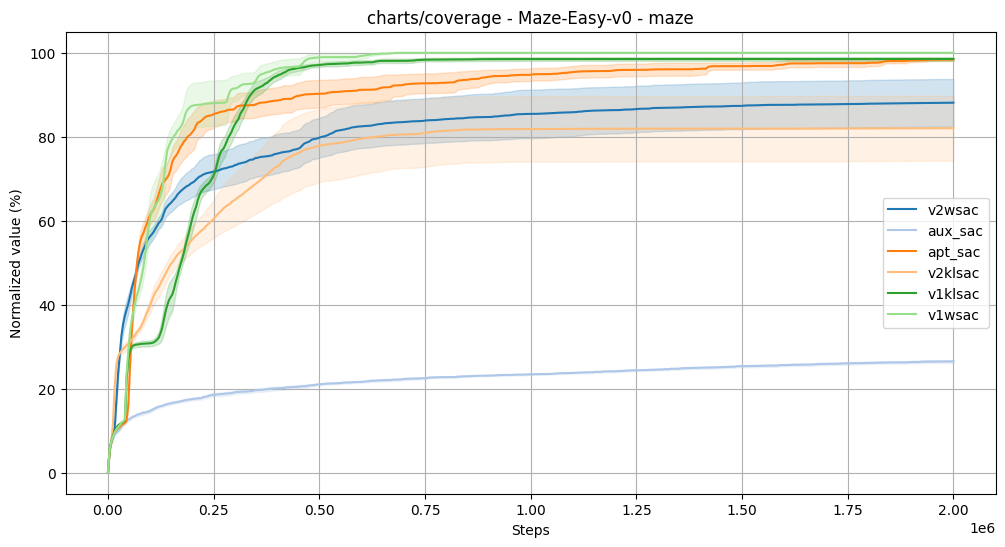

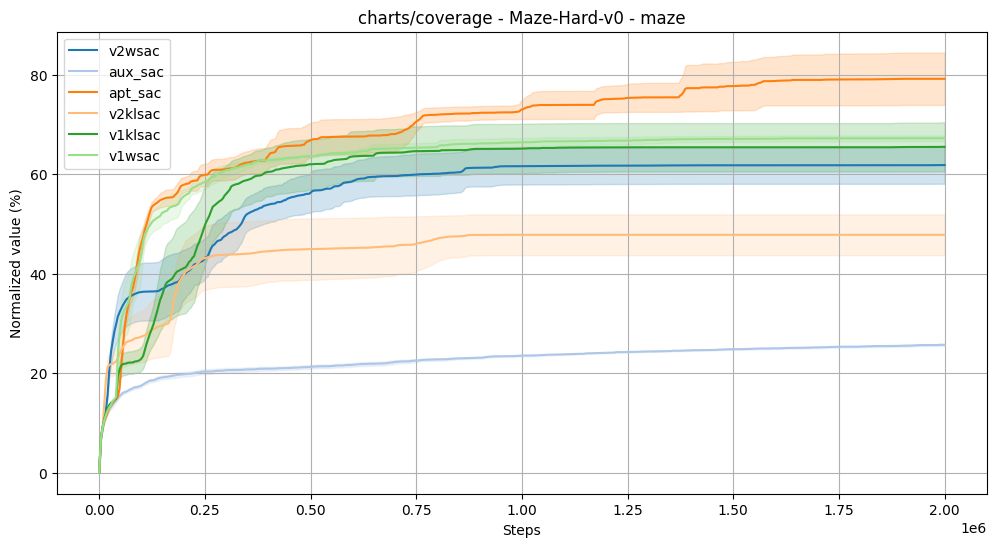

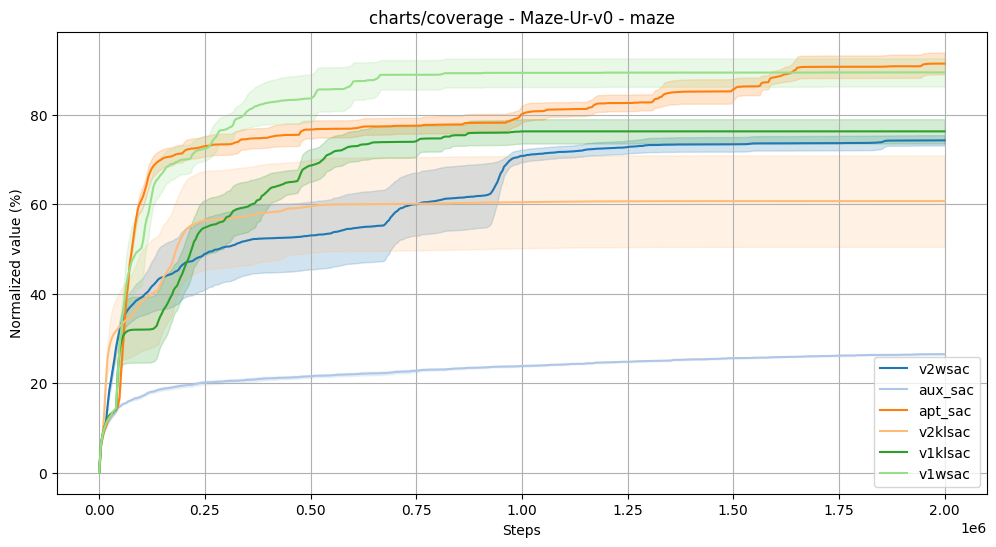

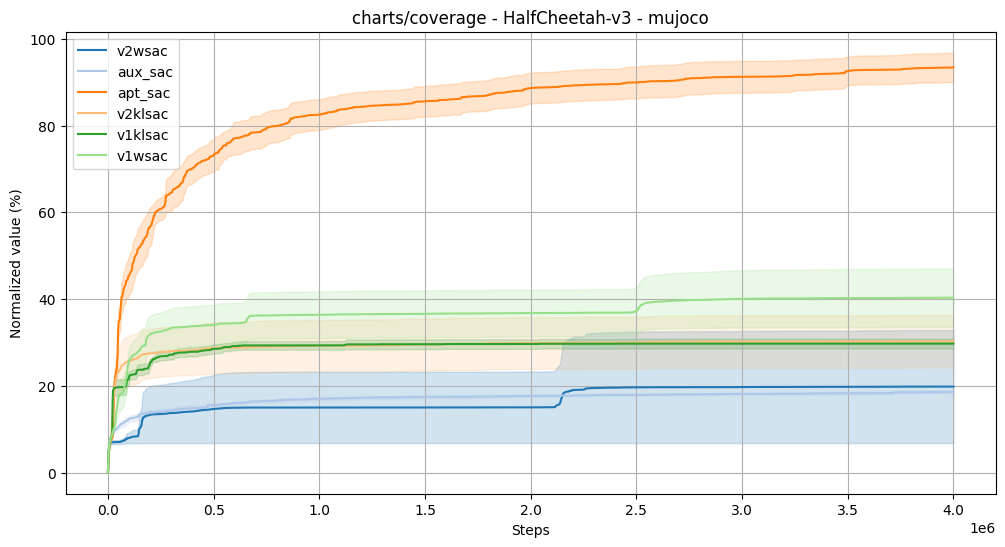

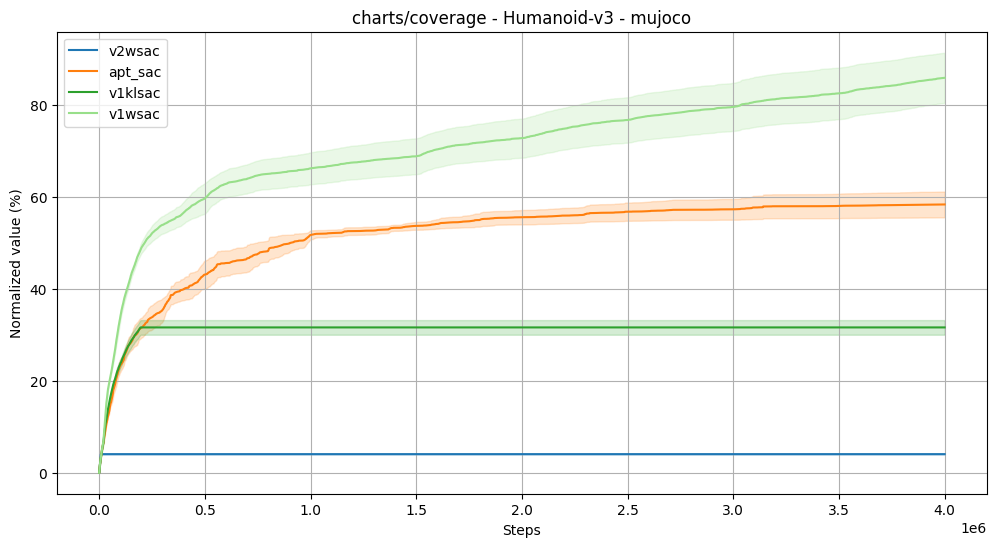

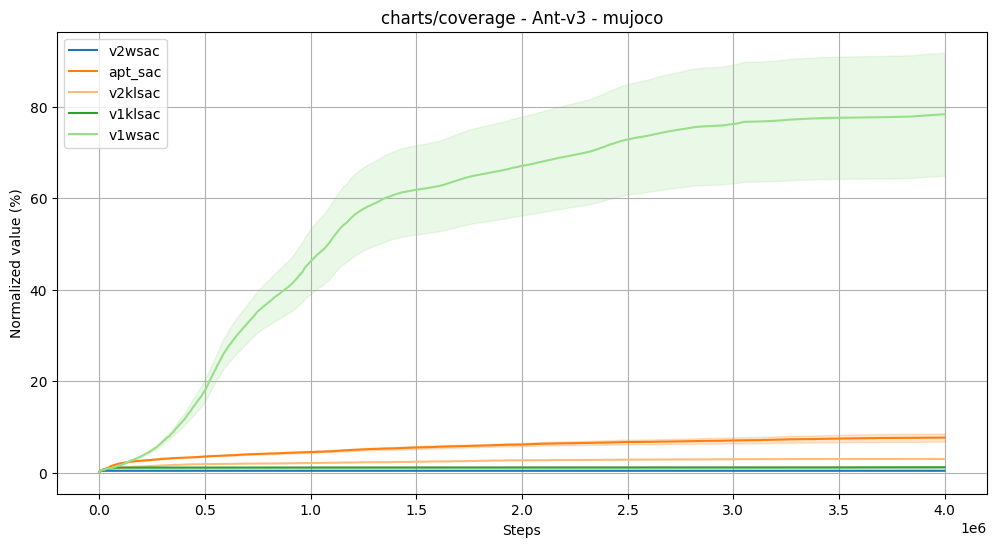

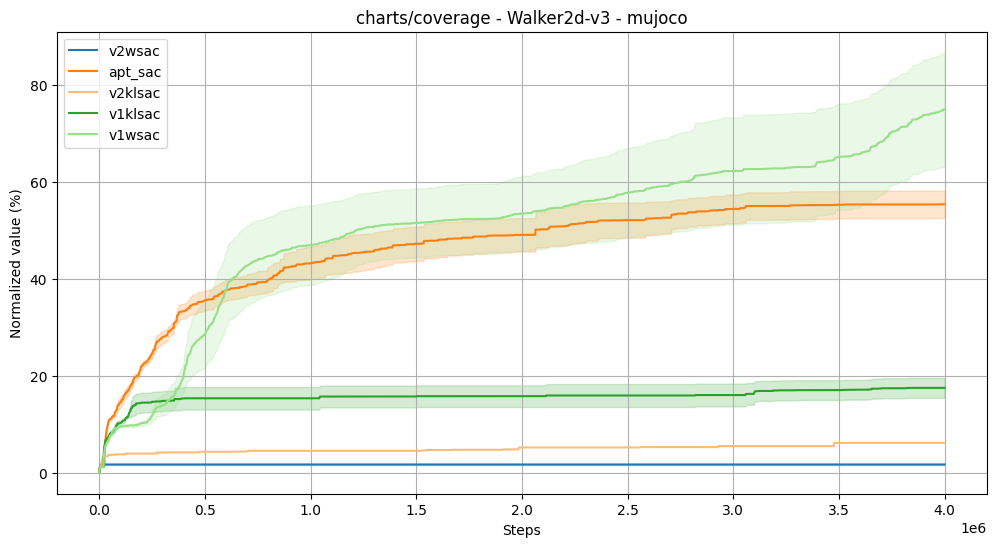

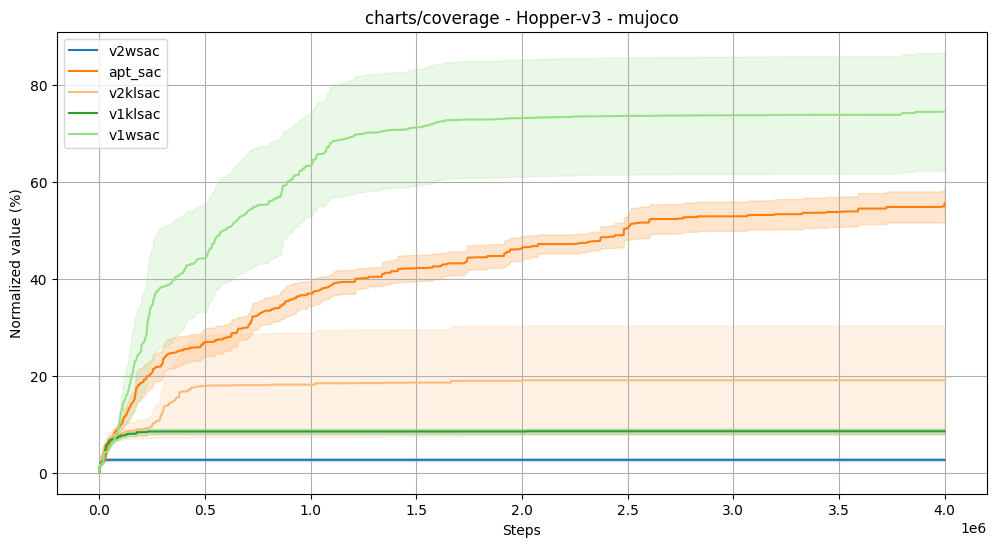

In [23]:

# Déterminer les couleurs pour chaque algorithme
palette = plt.get_cmap("tab20").colors
color_map = {exp_name: palette[i % len(palette)] for i, exp_name in enumerate(data_clean.keys())}
key_plot = ['charts/coverage']
for type_id in data_clean[list(data_clean.keys())[0]].keys():
    for env in data_clean[list(data_clean.keys())[0]][type_id].keys():
        for data_key in key_plot : 
            plt.figure(figsize=(12, 6))
            # try : 
            for exp_name in data_clean.keys():
                if env in data_clean[exp_name][type_id]:
                    # if exp_name != algo:
                    #     continue
                    # if data_key not in data[type_id][env]:
                    #     continue
                    # x = data[type_id][env]['_step']
                    if type_id=='mujoco' :
                        x= np.linspace(0, TOTAL_TIME_STEPS*NUM_ENVS,data_clean[exp_name][type_id][env]['normalized_mean_'+data_key].shape[0])
                    else:
                        x = np.linspace(0, data_clean[exp_name][type_id][env]['max_step']*NUM_ENVS, data_clean[exp_name][type_id][env]['normalized_mean_'+data_key].shape[0])
                    mean = data_clean[exp_name][type_id][env]['normalized_mean_'+data_key][:len(x)] 
                    std = data_clean[exp_name][type_id][env]['normalized_std_'+data_key][:len(x)]               
                    ste = data_clean[exp_name][type_id][env]['normalized_ste_'+data_key][:len(x)]
                    plt.plot(x, mean, label=traductor_exp(exp_name), color=color_map[exp_name])
                    plt.fill_between(x, mean - ste, mean + ste, color=color_map[exp_name], alpha=0.2)
            plt.title(f"{data_key} - {env} - {type_id}")
            plt.xlabel("Steps")
            plt.ylabel("Normalized value (%)")
            plt.legend()
            plt.grid(True)
            plt.show()
            # except Exception as e:
            #     print(e)
            #     print(f"Error in {exp_name} - {env} - {type_id} - {data_key}")
            #     continue
        

### Test maze plot 

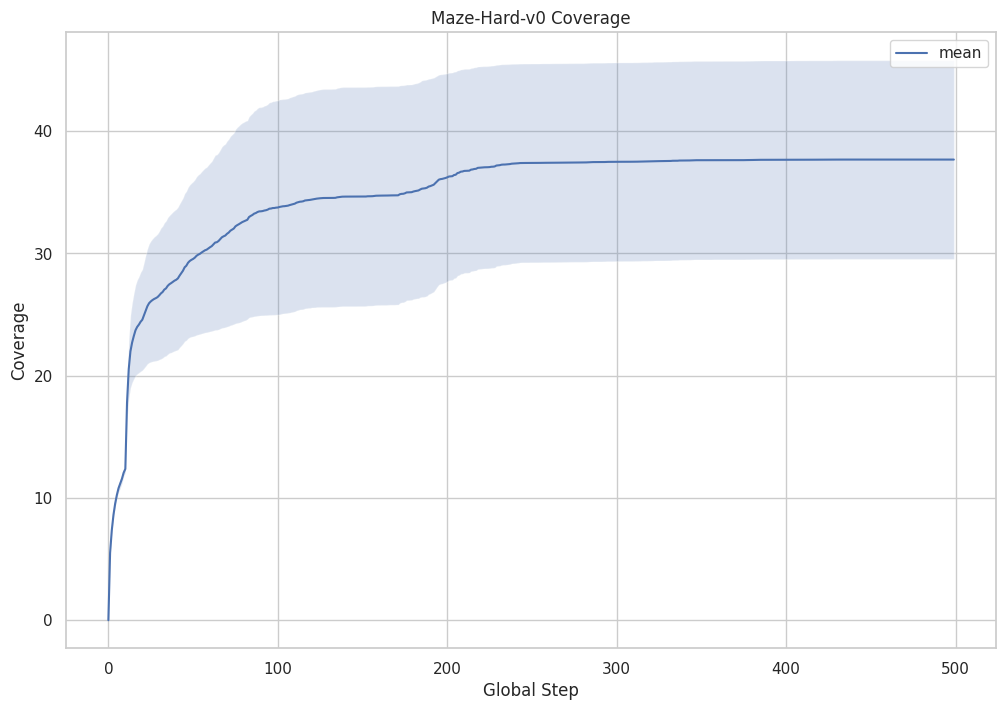

In [23]:
experiments_data['v2klsac']['maze']['Maze-Hard-v0'].keys()
# concat df covergae 
df_coverage = pd.concat([experiments_data['v2klsac']['maze']['Maze-Hard-v0'][seed]['history_metrics']['charts/coverage'] for seed in experiments_data['v2klsac']['maze']['Maze-Hard-v0'].keys()], axis=1)
# mean coverage on dim 1
df_coverage_mean = df_coverage.mean(axis=1)
# standard error coverage on dim 1
df_coverage_ste = df_coverage.std(axis=1) / np.sqrt(df_coverage.shape[1])

# figure 
plt.figure(figsize=(12, 8))
plt.plot(df_coverage_mean, label='mean')
plt.fill_between(df_coverage_mean.index, df_coverage_mean - df_coverage_ste, df_coverage_mean + df_coverage_ste, alpha=0.2)
plt.title('Maze-Hard-v0 Coverage')  
plt.xlabel('Global Step')
plt.ylabel('Coverage')
plt.legend()
plt.show()
